In [ ]:
!pip install gensim nltk newsapi-python

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from rouge import Rouge
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization, Dropout, GlobalAveragePooling1D

In [ ]:
# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Konfigurasi API Key untuk NewsAPI
NEWS_API_KEY2 = "dd771827b13443a49355e13dd9701157"
NEWS_API_ENDPOINT = "https://newsapi.org/v2/everything"

In [ ]:
# Fungsi untuk mengambil data dari NewsAPI
def fetch_news_data(query, language='en', page_size=100, page=1):
    params = {
        'q': query,
        'apiKey': NEWS_API_KEY2,
        'language': language,
        'pageSize': page_size,
        'page': page
    }

    response = requests.get(NEWS_API_ENDPOINT, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None

# Mengambil berita dari berbagai kategori untuk dataset yang lebih beragam
categories = ["technology", "politics", "business", "science", "health", "sports", "entertainment",
           "education", "environment", "finance", "medicine", "innovation", "artificial intelligence",
           "climate change", "space exploration", "bitcoin", "olympics", "COVID"]
all_articles = []

for category in categories:
    print(f"Mengambil artikel tentang {category}...")

    # Mengambil beberapa halaman artikel untuk setiap kategori
    for page in range(1, 3):  # 2 halaman per kategori
        news_data = fetch_news_data(query=category, language="en", page_size=100, page=page)

        if news_data and 'articles' in news_data:
            for article in news_data['articles']:
                if article['title'] and article['description'] and article['content']:
                    # Memastikan konten artikel tidak terlalu pendek
                    if len(article['content']) > 200:
                        all_articles.append({
                            'title': article['title'],
                            'description': article['description'],
                            'content': article['content'],
                            'category': category
                        })

    print(f"  Total artikel sejauh ini: {len(all_articles)}")

# Membuat DataFrame
df = pd.DataFrame(all_articles)

Mengambil artikel tentang technology...
Error: 426
{"status":"error","code":"maximumResultsReached","message":"You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results."}
  Total artikel sejauh ini: 84
Mengambil artikel tentang politics...
Error: 426
{"status":"error","code":"maximumResultsReached","message":"You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results."}
  Total artikel sejauh ini: 177
Mengambil artikel tentang business...
Error: 426
{"status":"error","code":"maximumResultsReached","message":"You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results."}
  Total artikel s

In [ ]:
# Simpan DataFrame ke CSV
csv_filename = 'apinews_articles_dataset.csv'
df.to_csv(csv_filename, index=False)
print(f"Dataset berhasil disimpan ke {csv_filename}")

# Untuk memastikan data tersimpan dengan baik, baca kembali dan tampilkan info
df_saved = pd.read_csv(csv_filename)
print(f"\nDataset yang disimpan berisi {len(df_saved)} artikel")
print("Contoh data yang tersimpan:")
display(df_saved.head())

Dataset berhasil disimpan ke apinews_articles_dataset.csv

Dataset yang disimpan berisi 1668 artikel
Contoh data yang tersimpan:


title  \
0  Grid-Scale Battery Storage Is Quietly Revoluti...   
1  The Verge is nominated for two Webby Awards — ...   
2  Firefly’s Alpha Rocket Crashes Into Pacific Oc...   
3  PM Modi and Elon Musk talk India-US tech colla...   
4                                Fun With Technology   

                                         description  \
0  This energy storage technology is harnessing t...   
1  The time of year has arrived â Webby Award s...   
2  The failure resulted in the loss of a Lockheed...   
3  Modi said he discussed with Musk India's poten...   
4  The power of makers and making is in battling ...   

                                             content    category  
0  Grid batteries have a halo effect for other po...  technology  
1  Voting for the Peoples Voice Award ends on Apr...  technology  
2  A Firefly Aerospace rocket failed to deliver i...  technology  
3  Indian Prime Minister Narendra Modi said he di...  technology  
4  This is a recording of the keynote talk I gave...  technology

In [ ]:
df = pd.read_csv('/content/apinews_articles_dataset.csv')

# Menampilkan informasi dataset
print("Informasi Dataset:")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")
print("\nDaftar kolom:")
print(df.columns.tolist())
print("\nContoh data:")
display(df.head())

Informasi Dataset:
Jumlah baris: 1668
Jumlah kolom: 4

Daftar kolom:
['title', 'description', 'content', 'category']

Contoh data:


title  \
0  Grid-Scale Battery Storage Is Quietly Revoluti...   
1  The Verge is nominated for two Webby Awards — ...   
2  Firefly’s Alpha Rocket Crashes Into Pacific Oc...   
3  PM Modi and Elon Musk talk India-US tech colla...   
4                                Fun With Technology   

                                         description  \
0  This energy storage technology is harnessing t...   
1  The time of year has arrived â Webby Award s...   
2  The failure resulted in the loss of a Lockheed...   
3  Modi said he discussed with Musk India's poten...   
4  The power of makers and making is in battling ...   

                                             content    category  
0  Grid batteries have a halo effect for other po...  technology  
1  Voting for the Peoples Voice Award ends on Apr...  technology  
2  A Firefly Aerospace rocket failed to deliver i...  technology  
3  Indian Prime Minister Narendra Modi said he di...  technology  
4  This is a recording of the keynote talk I gave...  technology


Distribusi kategori artikel:
category
science                    93
politics                   92
business                   91
olympics                   91
finance                    89
space exploration          89
education                  88
sports                     86
bitcoin                    83
technology                 83
medicine                   81
climate change             81
health                     81
environment                80
COVID                      73
innovation                 71
entertainment              71
artificial intelligence    62
Name: count, dtype: int64


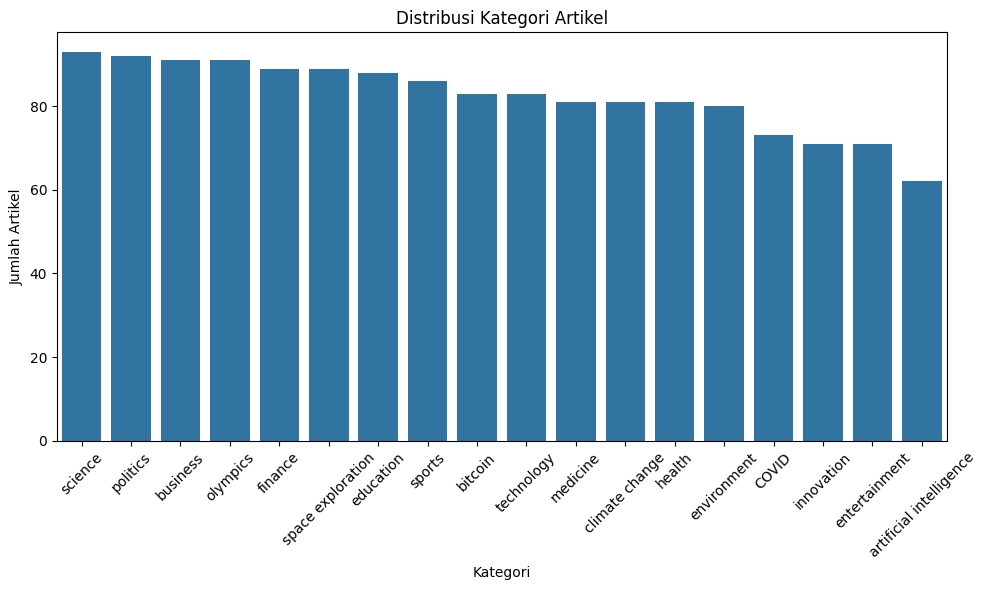


Jumlah artikel setelah menghapus duplikasi: 1485

Statistik panjang judul dan konten:
       title_length  text_length
count   1485.000000  1485.000000
mean      70.791246   213.981145
std       22.611438     0.400027
min       11.000000   211.000000
25%       56.000000   214.000000
50%       69.000000   214.000000
75%       82.000000   214.000000
max      241.000000   215.000000


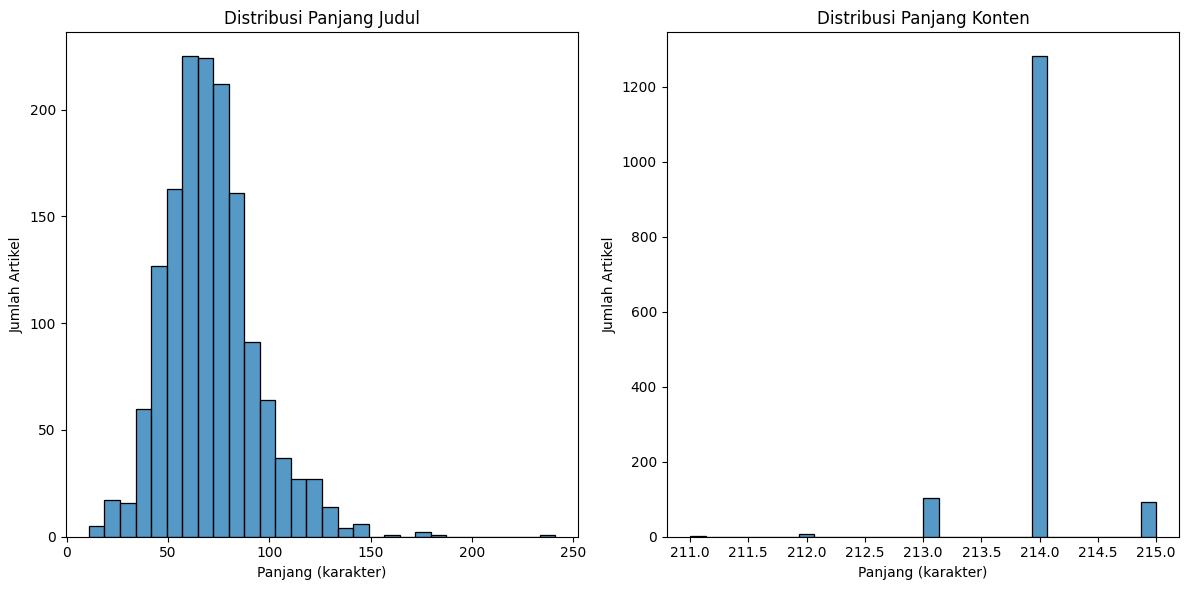


Jumlah nilai yang hilang:
title           0
description     0
content         0
category        0
title_length    0
text_length     0
dtype: int64


In [ ]:
# Memeriksa distribusi kategori
print("\nDistribusi kategori artikel:")
category_counts = df['category'].value_counts()
print(category_counts)

# Visualisasi distribusi kategori
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribusi Kategori Artikel')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Artikel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Menghapus duplikasi artikel berdasarkan judul
df = df.drop_duplicates(subset=['title'])
print(f"\nJumlah artikel setelah menghapus duplikasi: {len(df)}")

# Memeriksa panjang judul dan konten
df['title_length'] = df['title'].apply(len)
df['text_length'] = df['content'].apply(len)

print("\nStatistik panjang judul dan konten:")
print(df[['title_length', 'text_length']].describe())

# Visualisasi distribusi panjang
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['title_length'], bins=30)
plt.title('Distribusi Panjang Judul')
plt.xlabel('Panjang (karakter)')
plt.ylabel('Jumlah Artikel')

plt.subplot(1, 2, 2)
sns.histplot(df['text_length'], bins=30)
plt.title('Distribusi Panjang Konten')
plt.xlabel('Panjang (karakter)')
plt.ylabel('Jumlah Artikel')

plt.tight_layout()
plt.show()

# Memeriksa missing values
print("\nJumlah nilai yang hilang:")
print(df.isnull().sum())

Contoh hasil preprocessing:

Artikel 1:
Judul asli: Grid-Scale Battery Storage Is Quietly Revolutionizing the Energy System
Judul bersih: grid-scale battery storage is quietly revolutionizing the energy system
Judul seq2seq: startseq grid-scale battery storage is quietly revolutionizing the energy system endseq
Konten asli (100 karakter pertama): Grid batteries have a halo effect for other power generators too. Most thermal power plantscoal, gas...
Konten bersih (100 karakter pertama): grid batteries have a halo effect for other power generators too. most thermal power plantscoal, gas...

Artikel 2:
Judul asli: The Verge is nominated for two Webby Awards — help us win them!
Judul bersih: the verge is nominated for two webby awards  help us win them!
Judul seq2seq: startseq the verge is nominated for two webby awards  help us win them! endseq
Konten asli (100 karakter pertama): Voting for the Peoples Voice Award ends on April 17th, 2025.
Voting for the Peoples Voice Award end...
Konten 

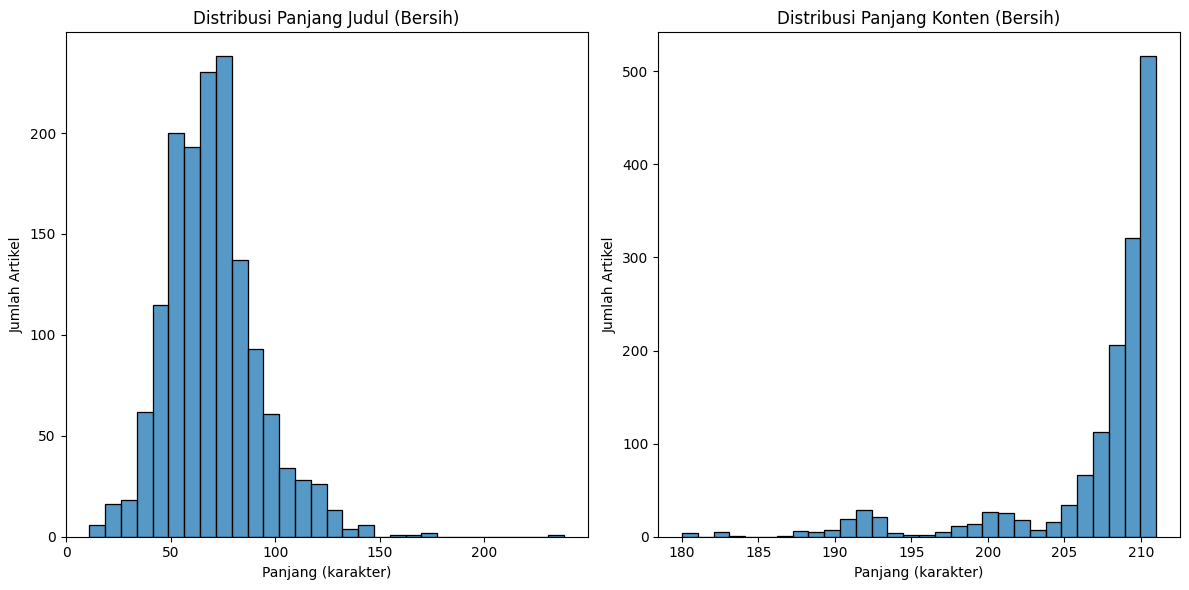

In [ ]:
# Fungsi preprocessing teks
def preprocess_text(text, is_title=False):
    if not isinstance(text, str):
        return ""

    # Mengubah ke lowercase
    text = text.lower()

    # Menghapus URL
    text = re.sub(r'http\S+', '', text)

    # Menghapus tag HTML
    text = re.sub(r'<.*?>', '', text)

    # Preprocessing lebih ringan untuk menghindari terlalu banyak penghapusan
    if is_title:
        text = re.sub(r'[^\w\s.,!?-]', '', text)
    else:
        text = re.sub(r'[^\w\s.,!?-]', '', text)

    # Trim whitespace
    text = text.strip()

    return text

# Menambahkan token khusus untuk sequence-to-sequence
def add_seq2seq_tokens(text, is_title=False):
    if is_title:
        return 'startseq ' + text + ' endseq'
    return text

# Preprocessing judul dan konten
df['clean_title'] = df['title'].apply(lambda x: preprocess_text(x, is_title=True))
df['clean_text'] = df['content'].apply(lambda x: preprocess_text(x, is_title=False))

# Menambahkan token khusus untuk sequence-to-sequence
df['seq2seq_title'] = df['clean_title'].apply(lambda x: add_seq2seq_tokens(x, is_title=True))

# Menampilkan contoh hasil preprocessing
print("Contoh hasil preprocessing:")
for i in range(min(3, len(df))):
    print(f"\nArtikel {i+1}:")
    print(f"Judul asli: {df.iloc[i]['title']}")
    print(f"Judul bersih: {df.iloc[i]['clean_title']}")
    print(f"Judul seq2seq: {df.iloc[i]['seq2seq_title']}")
    print(f"Konten asli (100 karakter pertama): {df.iloc[i]['content'][:100]}...")
    print(f"Konten bersih (100 karakter pertama): {df.iloc[i]['clean_text'][:100]}...")

# Mengatur threshold filter menjadi cukup rendah untuk mempertahankan data
min_title_length = 10  # Judul setidaknya 10 karakter
min_content_length = 100  # Konten setidaknya 100 karakter

# Memeriksa distribusi panjang sebelum filtering
print("\nDistribusi panjang sebelum filtering:")
df['clean_title_length'] = df['clean_title'].apply(len)
df['clean_text_length'] = df['clean_text'].apply(len)
print(df[['clean_title_length', 'clean_text_length']].describe())

# Memeriksa berapa banyak artikel yang akan difilter
n_short_titles = sum(df['clean_title_length'] < min_title_length)
n_short_contents = sum(df['clean_text_length'] < min_content_length)
n_both_short = sum((df['clean_title_length'] < min_title_length) & (df['clean_text_length'] < min_content_length))

print(f"\nArtikel dengan judul terlalu pendek (<{min_title_length} karakter): {n_short_titles}")
print(f"Artikel dengan konten terlalu pendek (<{min_content_length} karakter): {n_short_contents}")
print(f"Artikel dengan keduanya terlalu pendek: {n_both_short}")

# Filter artikel yang terlalu pendek
df_filtered = df[(df['clean_title_length'] >= min_title_length) &
                (df['clean_text_length'] >= min_content_length)]

print(f"\nJumlah artikel setelah menghapus yang terlalu pendek: {len(df_filtered)}")

# Jika dataset sudah cukup, gunakan data tersebut
if len(df_filtered) > 100:  # Minimal 100 artikel untuk pelatihan
    df = df_filtered
else:
    # Jika tidak cukup, gunakan dataset asli tanpa filter panjang
    print("\nWARNING: Terlalu sedikit artikel setelah filtering. Menggunakan dataset asli...")

# Memeriksa distribusi panjang setelah preprocessing
print("\nStatistik panjang setelah preprocessing (dan filtering jika ada data):")
print(df[['clean_title_length', 'clean_text_length']].describe())

# Visualisasi distribusi panjang setelah preprocessing
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['clean_title_length'], bins=30)
plt.title('Distribusi Panjang Judul (Bersih)')
plt.xlabel('Panjang (karakter)')
plt.ylabel('Jumlah Artikel')

plt.subplot(1, 2, 2)
sns.histplot(df['clean_text_length'], bins=30)
plt.title('Distribusi Panjang Konten (Bersih)')
plt.xlabel('Panjang (karakter)')
plt.ylabel('Jumlah Artikel')

plt.tight_layout()
plt.show()

In [ ]:
# Tokenisasi untuk konten artikel (input)
content_tokenizer = Tokenizer(oov_token='<UNK>')
content_tokenizer.fit_on_texts(df['clean_text'])
content_vocab_size = len(content_tokenizer.word_index) + 1  # +1 untuk padding

# Tokenisasi untuk judul artikel (output)
title_tokenizer = Tokenizer(oov_token='<UNK>')
title_tokenizer.fit_on_texts(df['seq2seq_title'])
title_vocab_size = len(title_tokenizer.word_index) + 1  # +1 untuk padding

print(f"Ukuran kosakata input (konten): {content_vocab_size}")
print(f"Ukuran kosakata output (judul): {title_vocab_size}")

# Konversi teks ke sekuens
content_sequences = content_tokenizer.texts_to_sequences(df['clean_text'])
title_sequences = title_tokenizer.texts_to_sequences(df['seq2seq_title'])

# Menghitung panjang rata-rata sekuens dan mengatur panjang maksimum
avg_content_length = np.mean([len(seq) for seq in content_sequences])
avg_title_length = np.mean([len(seq) for seq in title_sequences])

print(f"Panjang rata-rata sekuens konten: {avg_content_length:.2f} token")
print(f"Panjang rata-rata sekuens judul: {avg_title_length:.2f} token")

# Menentukan panjang maksimum sekuens (95 persentil dari distribusi token)
max_content_length = min(int(np.percentile([len(seq) for seq in content_sequences], 95)), 500)
max_title_length = min(int(np.percentile([len(seq) for seq in title_sequences], 95)), 30)

print(f"Panjang maksimum sekuens konten: {max_content_length} token")
print(f"Panjang maksimum sekuens judul: {max_title_length} token")

# Padding sekuens
content_padded = pad_sequences(content_sequences, maxlen=max_content_length, padding='post', truncating='post')
title_padded = pad_sequences(title_sequences, maxlen=max_title_length, padding='post', truncating='post')

print(f"Bentuk data konten setelah padding: {content_padded.shape}")
print(f"Bentuk data judul setelah padding: {title_padded.shape}")

# Mempersiapkan data untuk decoder (input dan target output)
decoder_input = title_padded[:, :-1]  # Semua kecuali token terakhir
decoder_target = title_padded[:, 1:]  # Semua kecuali token pertama

print(f"Bentuk data input decoder: {decoder_input.shape}")
print(f"Bentuk data target decoder: {decoder_target.shape}")

# Membagi data menjadi train dan validation
X_train, X_val, y_train_in, y_val_in, y_train_out, y_val_out = train_test_split(
    content_padded, decoder_input, decoder_target,
    test_size=0.2, random_state=42
)

print("\nUkuran dataset:")
print(f"Training: {X_train.shape[0]} contoh")
print(f"Validation: {X_val.shape[0]} contoh")

# Menyimpan tokenizer dan parameter penting
params = {
    'content_vocab_size': content_vocab_size,
    'title_vocab_size': title_vocab_size,
    'max_content_length': max_content_length,
    'max_title_length': max_title_length
}

with open('transformer_content_tokenizer.pickle', 'wb') as handle:
    pickle.dump(content_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('transformer_title_tokenizer.pickle', 'wb') as handle:
    pickle.dump(title_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('transformer_params.pickle', 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\nTokenizer dan parameter telah disimpan")

Ukuran kosakata input (konten): 11314
Ukuran kosakata output (judul): 5335
Panjang rata-rata sekuens konten: 35.11 token
Panjang rata-rata sekuens judul: 13.82 token
Panjang maksimum sekuens konten: 40 token
Panjang maksimum sekuens judul: 22 token
Bentuk data konten setelah padding: (1485, 40)
Bentuk data judul setelah padding: (1485, 22)
Bentuk data input decoder: (1485, 21)
Bentuk data target decoder: (1485, 21)

Ukuran dataset:
Training: 1188 contoh
Validation: 297 contoh

Tokenizer dan parameter telah disimpan


Bentuk positional encoding: (1, 50, 512)


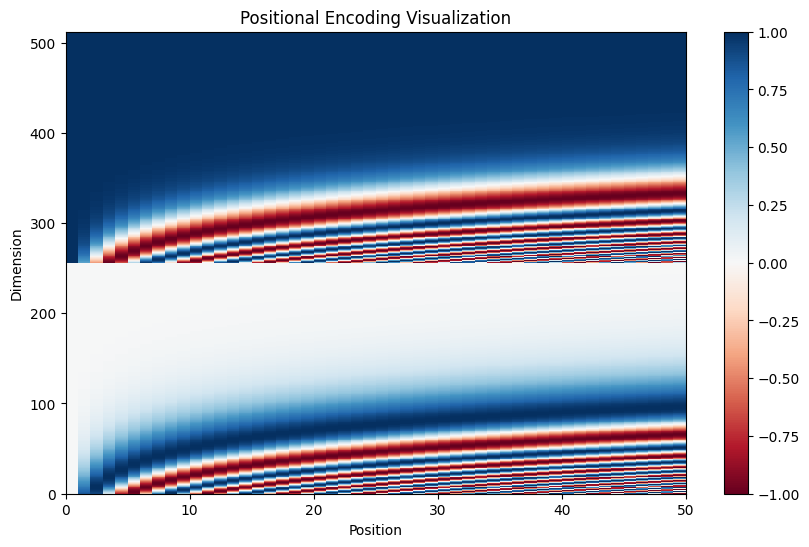

In [ ]:
# Implementasi Positional Encoding
def positional_encoding(length, depth):
    """
    Membuat positional encoding untuk input transformer.

    Args:
        length: Panjang sekuens
        depth: Dimensi embedding

    Returns:
        Tensor positional encoding dengan bentuk [1, length, depth]
    """
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]    # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth  # (1, depth)

    angle_rates = 1 / (10000**depths)               # (1, depth)
    angle_rads = positions * angle_rates            # (seq, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

# Lapisan yang menambahkan positional encoding
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(2048, d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # Scale embedding by sqrt(d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Add positional encoding
        x = x + self.pos_encoding[:, :length, :]
        return x

# Implementasi Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model//num_heads)
        self.ffn1 = tf.keras.layers.Dense(dff, activation='relu')
        self.ffn2 = tf.keras.layers.Dense(d_model)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False, mask=None):
        x = inputs  # Ekstrak input utama

        # Multi-head attention dengan residual connection dan layer normalization
        attn_output = self.mha(
            query=x, value=x, key=x,
            attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        # Feed forward network dengan residual connection dan layer normalization
        ffn_output = self.ffn1(out1)
        ffn_output = self.ffn2(ffn_output)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# Implementasi Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model//num_heads)
        self.mha2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model//num_heads)

        self.ffn1 = tf.keras.layers.Dense(dff, activation='relu')
        self.ffn2 = tf.keras.layers.Dense(d_model)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False, look_ahead_mask=None, padding_mask=None):
        x, enc_output = inputs  # Ekstrak input (decoder input, encoder output)

        # Self attention yang hanya bisa melihat token sebelumnya (masked self-attention)
        attn1 = self.mha1(
            query=x, value=x, key=x,
            attention_mask=look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        # Multi-head attention melihat output dari encoder
        attn2 = self.mha2(
            query=out1, value=enc_output, key=enc_output,
            attention_mask=padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        # Feed forward network
        ffn_output = self.ffn1(out2)
        ffn_output = self.ffn2(ffn_output)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3

# Padding mask
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Add extra dimensions to add the padding to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

# Look-ahead mask untuk decoder
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

# Kombinasi mask untuk decoder
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Decoder padding mask - untuk multi-head attention yang melihat output encoder
    dec_padding_mask = create_padding_mask(inp)

    # Decoder look ahead mask - tidak bisa melihat token-token masa depan
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

# Demo positional encoding
pos_encoding = positional_encoding(50, 512)
print(f"Bentuk positional encoding: {pos_encoding.shape}")

plt.figure(figsize=(10, 6))
plt.pcolormesh(pos_encoding[0].numpy().T, cmap='RdBu')
plt.title('Positional Encoding Visualization')
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.colorbar()
plt.show()

In [ ]:
# Implementasi Transformer menggunakan Keras API
def build_transformer_keras(params, num_layers=4, d_model=128, num_heads=8, dff=512, dropout_rate=0.1):
    """
    Membangun model transformer menggunakan pendekatan Keras API murni
    """
    # Encoder inputs
    encoder_inputs = tf.keras.layers.Input(shape=(params['max_content_length'],), name='encoder_inputs')

    # Decoder inputs
    decoder_inputs = tf.keras.layers.Input(shape=(params['max_title_length']-1,), name='decoder_inputs')

    # Embeddings
    # Encoder embedding
    encoder_embedding = tf.keras.layers.Embedding(
        params['content_vocab_size'], d_model, name='encoder_embedding')(encoder_inputs)
    encoder_embedding = tf.keras.layers.Dropout(dropout_rate)(encoder_embedding)

    # Decoder embedding
    decoder_embedding = tf.keras.layers.Embedding(
        params['title_vocab_size'], d_model, name='decoder_embedding')(decoder_inputs)
    decoder_embedding = tf.keras.layers.Dropout(dropout_rate)(decoder_embedding)

    # Encoder block
    encoder_outputs = encoder_embedding

    for i in range(num_layers):
        # Self-attention
        attn_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model//num_heads,
            name=f'encoder_attention_{i}'
        )(encoder_outputs, encoder_outputs, encoder_outputs)

        attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
        attn_output = tf.keras.layers.LayerNormalization(
            epsilon=1e-6, name=f'encoder_layernorm_1_{i}'
        )(encoder_outputs + attn_output)

        # Feed-forward
        ffn_output = tf.keras.layers.Dense(
            dff, activation='relu', name=f'encoder_ffn_1_{i}'
        )(attn_output)
        ffn_output = tf.keras.layers.Dense(
            d_model, name=f'encoder_ffn_2_{i}'
        )(ffn_output)
        ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)

        encoder_outputs = tf.keras.layers.LayerNormalization(
            epsilon=1e-6, name=f'encoder_layernorm_2_{i}'
        )(attn_output + ffn_output)

    # Decoder block
    decoder_outputs = decoder_embedding

    for i in range(num_layers):
        # Self-attention with causal mask (look-ahead mask)
        self_attn_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model//num_heads,
            name=f'decoder_self_attention_{i}'
        )(
            decoder_outputs, decoder_outputs, decoder_outputs,
            use_causal_mask=True  # Keras handles the causal mask automatically
        )

        self_attn_output = tf.keras.layers.Dropout(dropout_rate)(self_attn_output)
        self_attn_output = tf.keras.layers.LayerNormalization(
            epsilon=1e-6, name=f'decoder_layernorm_1_{i}'
        )(decoder_outputs + self_attn_output)

        # Cross-attention
        cross_attn_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model//num_heads,
            name=f'decoder_cross_attention_{i}'
        )(
            self_attn_output, encoder_outputs, encoder_outputs
        )

        cross_attn_output = tf.keras.layers.Dropout(dropout_rate)(cross_attn_output)
        cross_attn_output = tf.keras.layers.LayerNormalization(
            epsilon=1e-6, name=f'decoder_layernorm_2_{i}'
        )(self_attn_output + cross_attn_output)

        # Feed-forward
        ffn_output = tf.keras.layers.Dense(
            dff, activation='relu', name=f'decoder_ffn_1_{i}'
        )(cross_attn_output)
        ffn_output = tf.keras.layers.Dense(
            d_model, name=f'decoder_ffn_2_{i}'
        )(ffn_output)
        ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)

        decoder_outputs = tf.keras.layers.LayerNormalization(
            epsilon=1e-6, name=f'decoder_layernorm_3_{i}'
        )(cross_attn_output + ffn_output)

    # Final output layer
    outputs = tf.keras.layers.Dense(params['title_vocab_size'], name='output_layer')(decoder_outputs)

    # Create model
    model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)

    # Custom learning rate scheduler
    class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __init__(self, d_model, warmup_steps=4000):
            super().__init__()
            self.d_model = tf.cast(d_model, tf.float32)
            self.warmup_steps = warmup_steps

        def __call__(self, step):
            step = tf.cast(step, tf.float32)
            arg1 = tf.math.rsqrt(step)
            arg2 = step * (self.warmup_steps ** -1.5)
            return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

        def get_config(self):
            return {
                "d_model": self.d_model,
                "warmup_steps": self.warmup_steps
            }

    # Optimizer with learning rate schedule
    learning_rate = CustomSchedule(d_model)
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    # Loss function that ignores padding tokens
    def masked_loss(y_true, y_pred):
        # Create mask to ignore padding tokens (value 0)
        mask = tf.math.logical_not(tf.math.equal(y_true, 0))
        mask = tf.cast(mask, dtype=tf.float32)

        # Apply sparse categorical crossentropy on non-padding tokens
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        loss *= mask

        # Return average loss over non-padding tokens
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    # Accuracy metric that ignores padding tokens
    def masked_accuracy(y_true, y_pred):
        # Create mask to ignore padding tokens (value 0)
        mask = tf.math.logical_not(tf.math.equal(y_true, 0))
        mask = tf.cast(mask, dtype=tf.float32)

        # Get predicted indices
        predictions = tf.argmax(y_pred, axis=-1)
        predictions = tf.cast(predictions, dtype=tf.int32)

        # Compare predictions with true values
        matches = tf.equal(y_true, predictions)
        matches = tf.cast(matches, dtype=tf.float32)
        matches *= mask

        # Return accuracy over non-padding tokens
        return tf.reduce_sum(matches) / tf.reduce_sum(mask)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=masked_loss,
        metrics=[masked_accuracy]
    )

    return model

# Membangun model transformer dengan implementasi Keras
transformer_model = build_transformer_keras(
    params,
    num_layers=4,
    d_model=128,
    num_heads=8,
    dff=512,
    dropout_rate=0.1
)

# Menampilkan ringkasan model
print("Model Transformer untuk Generasi Judul:")
transformer_model.summary()

# Plot architecture
tf.keras.utils.plot_model(
    transformer_model,
    to_file='transformer_model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
)

Model Transformer untuk Generasi Judul:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 40, 128)   │  1,448,192 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_80          │ (None, 40, 128)   │          0 │ encoder_embeddin… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_attention_0 │ (None, 40, 128)   │     66,048 │ dropout_80[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_80[0][0], │
│                     │                   │            │ dropout_80[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 40, 128)   │          0 │ encoder_attentio… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 40, 128)   │          0 │ dropout_80[0][0], │
│                     │                   │            │ dropout_83[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layernorm_… │ (None, 40, 128)   │        256 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_ffn_1_0     │ (None, 40, 512)   │     66,048 │ encoder_layernor… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_ffn_2_0     │ (None, 40, 128)   │     65,664 │ encoder_ffn_1_0[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, 40, 128)   │          0 │ encoder_ffn_2_0[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 40, 128)   │          0 │ encoder_layernor… │
│                     │                   │            │ dropout_84[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layernorm_… │ (None, 40, 128)   │        256 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_attention_1 │ (None, 40, 128)   │     66,048 │ encoder_layernor… │
│ (MultiHeadAttentio… │                   │            │ encoder_layernor… │
│                     │                   │            │ encoder_layernor… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_86          │ (None, 40, 128)   │          0 │ encoder_attentio… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 40, 128)   │          0 │ encoder_layernor… │
│                     │                   │            │ dropout_86[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layernorm_… │ (None, 40, 128)   │        256 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 4,670,679 (17.82 MB)

 Trainable params: 4,670,679 (17.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fungsi untuk membangun model RNN-LSTM sederhana
def build_rnn_lstm_model(params, embedding_dim=128, lstm_units=256):
    # Encoder (Input teks artikel)
    encoder_inputs = tf.keras.layers.Input(shape=(params['max_content_length'],), name='encoder_inputs')
    encoder_embedding = tf.keras.layers.Embedding(
        params['content_vocab_size'], embedding_dim,
        name='encoder_embedding')(encoder_inputs)
    encoder_lstm = tf.keras.layers.LSTM(
        lstm_units, return_state=True,
        name='encoder_lstm')
    _, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder (Generasi judul)
    decoder_inputs = tf.keras.layers.Input(shape=(params['max_title_length']-1,), name='decoder_inputs')
    decoder_embedding = tf.keras.layers.Embedding(
        params['title_vocab_size'], embedding_dim,
        name='decoder_embedding')(decoder_inputs)
    decoder_lstm = tf.keras.layers.LSTM(
        lstm_units, return_sequences=True, return_state=True,
        name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = tf.keras.layers.Dense(
        params['title_vocab_size'], activation='softmax',
        name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Model
    model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Fungsi untuk membangun model RNN-LSTM dengan Attention
def build_rnn_lstm_attention_model(params, embedding_dim=128, lstm_units=256):
    # Encoder (Input teks artikel)
    encoder_inputs = tf.keras.layers.Input(shape=(params['max_content_length'],), name='encoder_inputs')
    encoder_embedding = tf.keras.layers.Embedding(
        params['content_vocab_size'], embedding_dim,
        name='encoder_embedding')(encoder_inputs)
    encoder_lstm = tf.keras.layers.LSTM(
        lstm_units, return_sequences=True, return_state=True,
        name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder (Generasi judul)
    decoder_inputs = tf.keras.layers.Input(shape=(params['max_title_length']-1,), name='decoder_inputs')
    decoder_embedding = tf.keras.layers.Embedding(
        params['title_vocab_size'], embedding_dim,
        name='decoder_embedding')(decoder_inputs)
    decoder_lstm = tf.keras.layers.LSTM(
        lstm_units, return_sequences=True, return_state=True,
        name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    # Attention
    attention = tf.keras.layers.Attention()([decoder_outputs, encoder_outputs])
    decoder_concat = tf.keras.layers.Concatenate()([decoder_outputs, attention])

    # Output
    decoder_dense = tf.keras.layers.Dense(
        params['title_vocab_size'], activation='softmax',
        name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_concat)

    # Model
    model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Membangun model RNN-LSTM untuk perbandingan
rnn_lstm_model = build_rnn_lstm_model(params)
rnn_lstm_attention_model = build_rnn_lstm_attention_model(params)

# Menampilkan ringkasan model RNN-LSTM
print("Model RNN-LSTM Dasar:")
rnn_lstm_model.summary()

# Menampilkan ringkasan model RNN-LSTM dengan Attention
print("\nModel RNN-LSTM dengan Attention:")
rnn_lstm_attention_model.summary()

Model RNN-LSTM Dasar:


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 40, 128)   │  1,448,192 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 21, 128)   │    682,880 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    394,240 │ encoder_embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 21, 256), │    394,240 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 21, 5335)  │  1,371,095 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,290,647 (16.37 MB)

 Trainable params: 4,290,647 (16.37 MB)

 Non-trainable params: 0 (0.00 B)


Model RNN-LSTM dengan Attention:


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 40, 128)   │  1,448,192 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 21, 128)   │    682,880 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 40, 256), │    394,240 │ encoder_embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 21, 256), │    394,240 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 21, 256)   │          0 │ decoder_lstm[0][… │
│ (Attention)         │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 21, 512)   │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 21, 5335)  │  2,736,855 │ concatenate_3[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,656,407 (21.58 MB)

 Trainable params: 5,656,407 (21.58 MB)

 Non-trainable params: 0 (0.00 B)

Melatih model Transformer...
Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 8.5442 - masked_accuracy: 0.0049


Learning rate untuk epoch 1: 0.00002655
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 8.5436 - masked_accuracy: 0.0053 - val_loss: 8.4530 - val_masked_accuracy: 0.0717
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - loss: 8.4102 - masked_accuracy: 0.0754


Learning rate untuk epoch 2: 0.00003983
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 8.4093 - masked_accuracy: 0.0754 - val_loss: 8.3272 - val_masked_accuracy: 0.0757
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - loss: 8.2659 - masked_accuracy: 0.0761


Learning rate untuk epoch 3: 0.00005311
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 8.2650 - masked_accuracy: 0.0761 - val_loss: 8.2213 - val_masked_accuracy: 0.0757
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - loss: 8.1238 - masked_accuracy: 0.0761


Learning rate untuk epoch 4: 0.00006638
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 8.1230 - masked_accuracy: 0.0761 - val_loss: 8.1127 - val_masked_accuracy: 0.0757
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - loss: 7.9658 - masked_accuracy: 0.0761


Learning rate untuk epoch 5: 0.00007966
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 7.9649 - masked_accuracy: 0.0761 - val_loss: 7.9916 - val_masked_accuracy: 0.0757
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - loss: 7.7889 - masked_accuracy: 0.0761


Learning rate untuk epoch 6: 0.00009294
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 7.7879 - masked_accuracy: 0.0761 - val_loss: 7.8625 - val_masked_accuracy: 0.0757
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 7.5973 - masked_accuracy: 0.0761


Learning rate untuk epoch 7: 0.00010621
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 7.5963 - masked_accuracy: 0.0761 - val_loss: 7.7349 - val_masked_accuracy: 0.0757
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - loss: 7.4055 - masked_accuracy: 0.0761


Learning rate untuk epoch 8: 0.00011949
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 7.4046 - masked_accuracy: 0.0761 - val_loss: 7.6237 - val_masked_accuracy: 0.0813
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 7.2243 - masked_accuracy: 0.0781


Learning rate untuk epoch 9: 0.00013277
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 7.2236 - masked_accuracy: 0.0781 - val_loss: 7.5393 - val_masked_accuracy: 0.0817
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 7.0645 - masked_accuracy: 0.0822


Learning rate untuk epoch 10: 0.00014604
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 7.0640 - masked_accuracy: 0.0822 - val_loss: 7.4857 - val_masked_accuracy: 0.0845
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - loss: 6.9220 - masked_accuracy: 0.0874


Learning rate untuk epoch 11: 0.00015932
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 6.9215 - masked_accuracy: 0.0875 - val_loss: 7.4447 - val_masked_accuracy: 0.0895
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - loss: 6.7792 - masked_accuracy: 0.0969


Learning rate untuk epoch 12: 0.00017260
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 6.7787 - masked_accuracy: 0.0970 - val_loss: 7.4170 - val_masked_accuracy: 0.0976
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - loss: 6.6351 - masked_accuracy: 0.1089
Learning rate untuk epoch 13: 0.00018587
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 6.6345 - masked_accuracy: 0.1090 - val_loss: 7.4572 - val_masked_accuracy: 0.0961
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - loss: 6.4913 - masked_accuracy: 0.1175
Learning rate untuk epoch 14: 0.00019915
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 6.4907 - masked_accuracy: 0.1176 - val_loss: 7.4230 - val_masked_accuracy: 0.0981
Epoch 15/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 6.3483 - masked_accuracy: 0.1245


Learning rate untuk epoch 15: 0.00021243
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 6.3474 - masked_accuracy: 0.1247 - val_loss: 7.4051 - val_masked_accuracy: 0.1123
Epoch 16/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - loss: 6.2092 - masked_accuracy: 0.1420
Learning rate untuk epoch 16: 0.00022570
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 6.2081 - masked_accuracy: 0.1421 - val_loss: 7.4081 - val_masked_accuracy: 0.1113
Epoch 17/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - loss: 6.0362 - masked_accuracy: 0.1604
Learning rate untuk epoch 17: 0.00023898
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 6.0352 - masked_accuracy: 0.1605 - val_loss: 7.4535 - val_masked_accuracy: 0.1040
Epoch 18/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - loss: 5.8646 - masked_accuracy: 0.1731
Learning rate untuk epoch 18: 0.00025226
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 5.8638 - masked_accuracy: 0.1732 - val_loss: 7.4942 - val_masked_accuracy: 0.1037
Epoch 19/20
38/38 ━━━━━━━━━━━━━━━━━━━

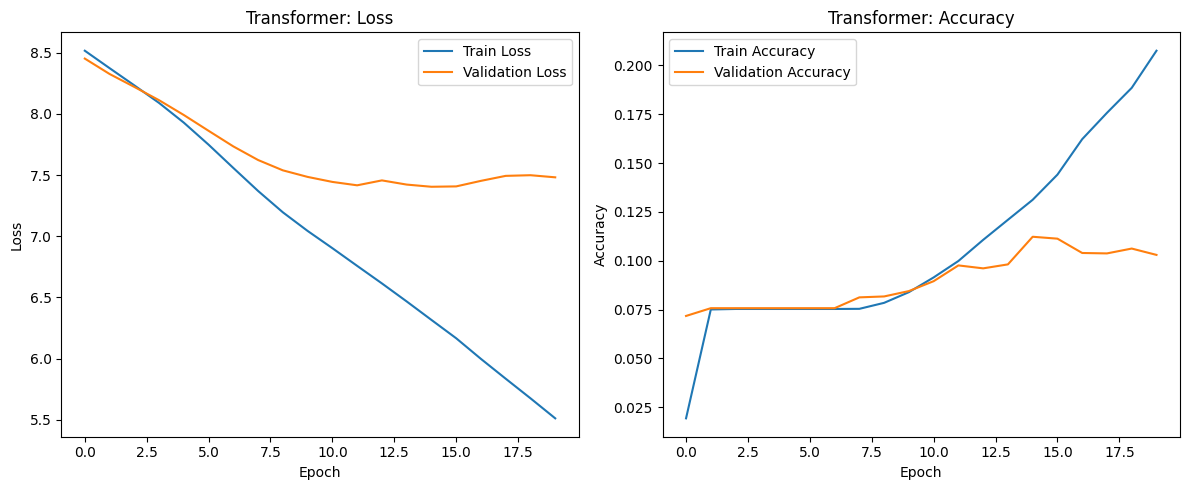

In [ ]:
# Callback untuk early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Callback untuk model checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'transformer_model_best.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Callback untuk mencetak learning rate di setiap epoch
class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Cara yang lebih kompatibel untuk mendapatkan learning rate saat ini
        current_lr = self.model.optimizer.learning_rate
        if hasattr(current_lr, 'numpy'):
            lr_value = current_lr.numpy()
        elif hasattr(current_lr, '__call__'):
            # Jika learning rate adalah callable (scheduler)
            step = self.model.optimizer.iterations.numpy()
            lr_value = current_lr(step).numpy()
        else:
            # Fallback
            lr_value = float(current_lr)

        print(f"\nLearning rate untuk epoch {epoch+1}: {lr_value:.8f}")

# Melatih model Transformer
print("Melatih model Transformer...")

transformer_history = transformer_model.fit(
    [X_train, y_train_in], y_train_out,
    validation_data=([X_val, y_val_in], y_val_out),
    batch_size=32,  # Ukuran batch yang lebih kecil karena kompleksitas model
    epochs=10,
    callbacks=[early_stopping, checkpoint, LRLogger()]
)

# Menyimpan history pelatihan
with open('transformer_history.pickle', 'wb') as handle:
    pickle.dump(transformer_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plot kurva loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(transformer_history.history['loss'], label='Train Loss')
plt.plot(transformer_history.history['val_loss'], label='Validation Loss')
plt.title('Transformer: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(transformer_history.history['masked_accuracy'], label='Train Accuracy')
plt.plot(transformer_history.history['val_masked_accuracy'], label='Validation Accuracy')
plt.title('Transformer: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Melatih model RNN-LSTM Dasar...
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3217 - loss: 7.9099 - val_accuracy: 0.3895 - val_loss: 4.9740
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3935 - loss: 4.7855 - val_accuracy: 0.3895 - val_loss: 4.8134
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3973 - loss: 4.4949 - val_accuracy: 0.3984 - val_loss: 4.7220
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4115 - loss: 4.3265 - val_accuracy: 0.4400 - val_loss: 4.6447
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4456 - loss: 4.2159 - val_accuracy: 0.4406 - val_loss: 4.6230
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4472 - loss: 4.1640 - val_accuracy: 0.4420 - val_loss: 4.6359
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4476 - loss: 4.1278 - val_accuracy: 0.4430 - val_loss: 4.6452
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4481 - loss: 4.0967 - 

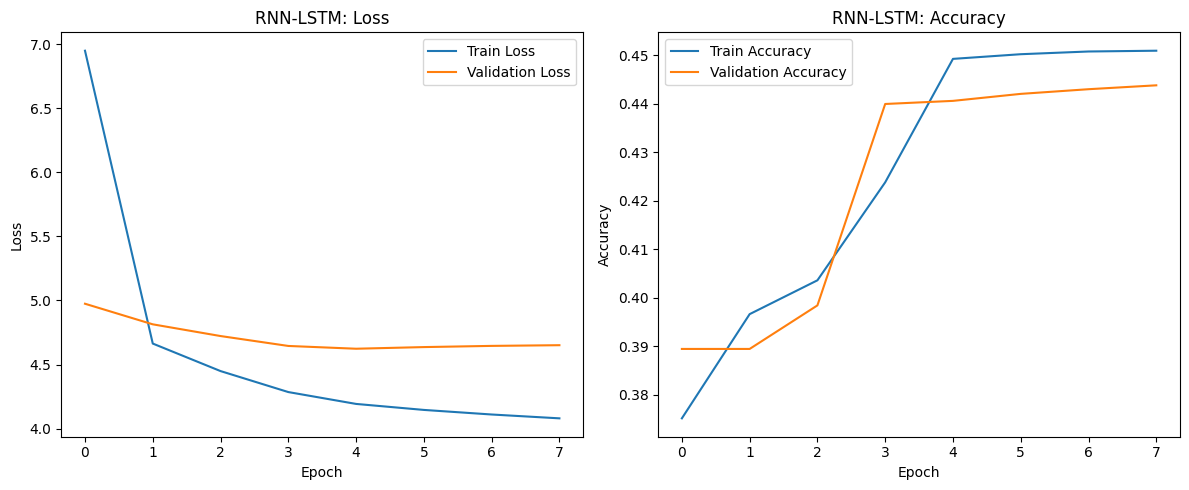

Melatih model RNN-LSTM dengan Attention...
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.3216 - loss: 7.6788 - val_accuracy: 0.3895 - val_loss: 4.8479
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.3958 - loss: 4.6771 - val_accuracy: 0.3987 - val_loss: 4.7428
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.4104 - loss: 4.3495 - val_accuracy: 0.4129 - val_loss: 4.7310
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.4364 - loss: 4.2281 - val_accuracy: 0.4408 - val_loss: 4.7180
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.4475 - loss: 4.1647 - val_accuracy: 0.4433 - val_loss: 4.7376
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.4479 - loss: 4.1165 - val_accuracy: 0.4433 - val_loss: 4.7709
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.4484 - loss: 4.0772 - val_accuracy: 0.4436 - val_loss: 4.8080


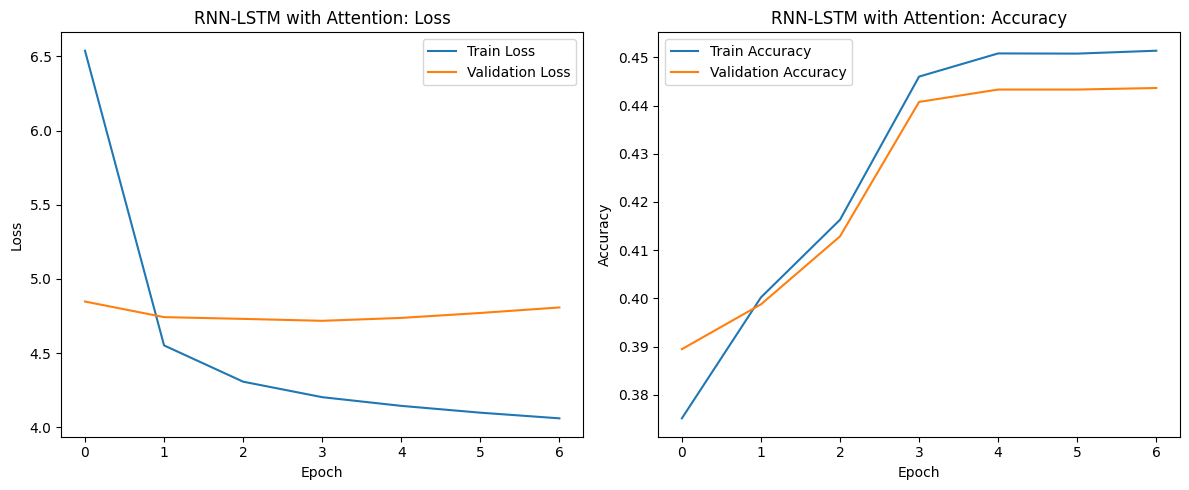

In [ ]:
# Callback untuk early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Melatih model RNN-LSTM dasar
print("Melatih model RNN-LSTM Dasar...")

rnn_lstm_history = rnn_lstm_model.fit(
    [X_train, y_train_in], y_train_out,
    validation_data=([X_val, y_val_in], y_val_out),
    batch_size=64,
    epochs=15,
    callbacks=[early_stopping]
)

# Menyimpan history pelatihan
with open('rnn_lstm_history.pickle', 'wb') as handle:
    pickle.dump(rnn_lstm_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plot kurva loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rnn_lstm_history.history['loss'], label='Train Loss')
plt.plot(rnn_lstm_history.history['val_loss'], label='Validation Loss')
plt.title('RNN-LSTM: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN-LSTM: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Melatih model RNN-LSTM dengan Attention
print("Melatih model RNN-LSTM dengan Attention...")

rnn_lstm_attention_history = rnn_lstm_attention_model.fit(
    [X_train, y_train_in], y_train_out,
    validation_data=([X_val, y_val_in], y_val_out),
    batch_size=64,
    epochs=15,
    callbacks=[early_stopping]
)

# Menyimpan history pelatihan
with open('rnn_lstm_attention_history.pickle', 'wb') as handle:
    pickle.dump(rnn_lstm_attention_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plot kurva loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rnn_lstm_attention_history.history['loss'], label='Train Loss')
plt.plot(rnn_lstm_attention_history.history['val_loss'], label='Validation Loss')
plt.title('RNN-LSTM with Attention: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_lstm_attention_history.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_lstm_attention_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN-LSTM with Attention: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Fungsi untuk menghasilkan judul dengan model Transformer
def generate_title_transformer(article_text, tokenizers, params, model, max_length=30):
    """
    Generate a title for an article using the transformer model

    Args:
        article_text: Text of the article
        tokenizers: Dictionary containing content_tokenizer and title_tokenizer
        params: Dictionary containing model parameters
        model: Trained transformer model
        max_length: Maximum length of generated title

    Returns:
        Generated title
    """
    # Preprocess article text
    article_text = preprocess_text(article_text)

    # Tokenize article
    content_tokenizer = tokenizers['content_tokenizer']
    title_tokenizer = tokenizers['title_tokenizer']

    article_seq = content_tokenizer.texts_to_sequences([article_text])
    article_padded = pad_sequences(article_seq, maxlen=params['max_content_length'],
                                  padding='post', truncating='post')

    # Initialize target sequence with start token
    start_token = title_tokenizer.word_index.get('startseq', 1)
    output_seq = tf.expand_dims([start_token], 0)

    # Keep track of generated tokens
    result = []

    for i in range(max_length):
        predictions = model([article_padded, output_seq], training=False)

        # Get the predicted token (last position in sequence)
        predicted_id = tf.argmax(predictions[:, -1, :], axis=-1)
        predicted_id = predicted_id.numpy()[0]

        # Convert to word
        predicted_word = None
        for word, index in title_tokenizer.word_index.items():
            if index == predicted_id:
                predicted_word = word
                break

        # Break if end token or unknown
        if predicted_word == 'endseq' or predicted_word is None:
            break

        # Add to result if not special token
        if predicted_word not in ['startseq', 'endseq']:
            result.append(predicted_word)

        # Update output sequence for next prediction
        output_seq = tf.concat([output_seq, tf.expand_dims([predicted_id], 0)], axis=1)

    return ' '.join(result)

# Fungsi untuk menghasilkan judul dengan model RNN-LSTM
def generate_title_rnn_lstm(article_text, tokenizers, params, encoder_model, decoder_model, max_length=30):
    """
    Generate a title for an article using the RNN-LSTM model

    Args:
        article_text: Text of the article
        tokenizers: Dictionary containing content_tokenizer and title_tokenizer
        params: Dictionary containing model parameters
        encoder_model: Trained encoder model for inference
        decoder_model: Trained decoder model for inference
        max_length: Maximum length of generated title

    Returns:
        Generated title
    """
    # Preprocess article text
    article_text = preprocess_text(article_text)

    # Tokenize article
    content_tokenizer = tokenizers['content_tokenizer']
    title_tokenizer = tokenizers['title_tokenizer']

    article_seq = content_tokenizer.texts_to_sequences([article_text])
    article_padded = pad_sequences(article_seq, maxlen=params['max_content_length'],
                                  padding='post', truncating='post')

    # Get encoder output
    states_value = encoder_model.predict(article_padded, verbose=0)

    # Initialize target sequence with start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = title_tokenizer.word_index.get('startseq', 1)

    # Store generated words
    generated_title = []

    # Generation loop
    for _ in range(max_length):
        # Predict next word
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Get the predicted word index
        predicted_index = np.argmax(output_tokens[0, 0, :])

        # Convert index to word
        predicted_word = None
        for word, index in title_tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break

        # Handle unknown words
        if predicted_word is None:
            predicted_word = "<UNK>"

        # Break if end token or reached max length
        if predicted_word == 'endseq':
            break

        # Add the word to the generated title
        if predicted_word not in ['startseq', 'endseq']:
            generated_title.append(predicted_word)

        # Update the target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = predicted_index

        # Update states
        states_value = [h, c]

    return ' '.join(generated_title)

In [ ]:
# Memuat tokenizer
with open('transformer_content_tokenizer.pickle', 'rb') as handle:
    content_tokenizer = pickle.load(handle)

with open('transformer_title_tokenizer.pickle', 'rb') as handle:
    title_tokenizer = pickle.load(handle)

tokenizers = {
    'content_tokenizer': content_tokenizer,
    'title_tokenizer': title_tokenizer
}

# Memuat parameter model
with open('transformer_params.pickle', 'rb') as handle:
    params = pickle.load(handle)

# Memuat model terbaik untuk inferensi
try:
    transformer_model = tf.keras.models.load_model(
        'transformer_model_best.h5',
        custom_objects={
            'CustomSchedule': CustomSchedule,
            'masked_loss': masked_loss,
            'masked_accuracy': masked_accuracy
        }
    )
    print("Model transformer terbaik berhasil dimuat")
except:
    print("Model transformer terbaik tidak ditemukan, menggunakan model saat ini")

# Untuk model RNN-LSTM, kita perlu memisahkan encoder dan decoder untuk inferensi
def create_rnn_lstm_inference_models(model):
    # Encoder model
    encoder_inputs = model.input[0]
    encoder_embedding = model.get_layer('encoder_embedding')(encoder_inputs)
    encoder_lstm = model.get_layer('encoder_lstm')
    _, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

    # Decoder model
    decoder_inputs = tf.keras.layers.Input(shape=(1,))
    decoder_embedding = model.get_layer('decoder_embedding')(decoder_inputs)
    decoder_lstm = model.get_layer('decoder_lstm')

    decoder_state_input_h = tf.keras.layers.Input(shape=(model.get_layer('decoder_lstm').units,))
    decoder_state_input_c = tf.keras.layers.Input(shape=(model.get_layer('decoder_lstm').units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]

    decoder_dense = model.get_layer('decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states
    )

    return encoder_model, decoder_model

# Membuat model inferensi untuk RNN-LSTM
rnn_lstm_encoder_model, rnn_lstm_decoder_model = create_rnn_lstm_inference_models(rnn_lstm_model)
print("Model RNN-LSTM inferensi berhasil dibuat")

# Untuk model RNN-LSTM dengan attention, pendekatan inferensi lebih kompleks
# Kita akan menggunakan model Transformer untuk demo

Model transformer terbaik tidak ditemukan, menggunakan model saat ini
Model RNN-LSTM inferensi berhasil dibuat


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from tqdm import tqdm
import time

# Inisialisasi ROUGE
rouge = Rouge()

In [ ]:
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import requests
import pickle
import time

Evaluating models:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower 

Average Evaluation Metrics:


Metric    Transformer       RNN-LSTM
0           bleu1   5.362121e-03   3.903928e-02
1           bleu2  1.096840e-156  1.229884e-155
2           bleu3  7.298462e-206  9.615900e-205
3           bleu4  1.573931e-233  2.242163e-232
4          rouge1   5.669775e-02   6.854210e-02
5          rouge2   0.000000e+00   0.000000e+00
6          rougeL   5.669775e-02   5.854210e-02
0  inference_time   5.152853e-01   1.211925e+00

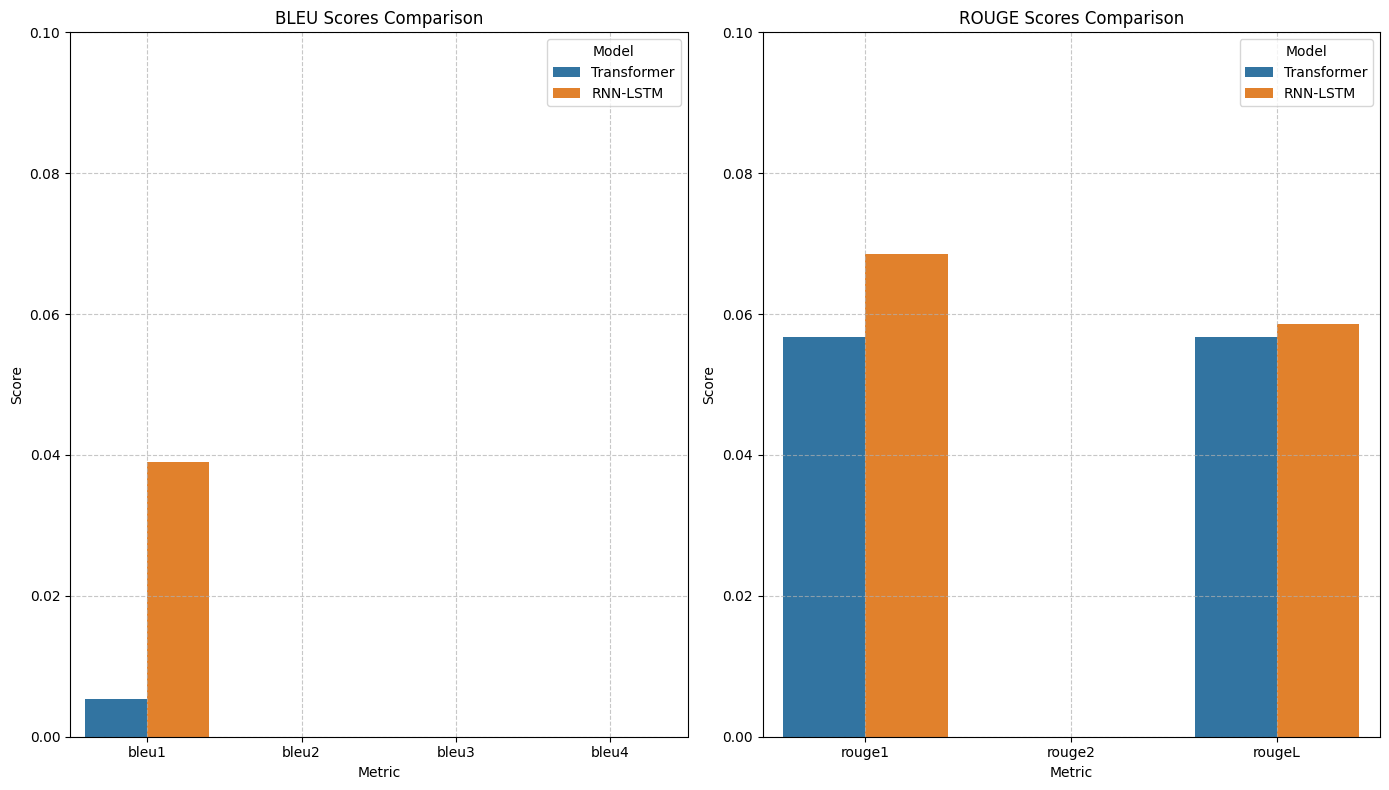

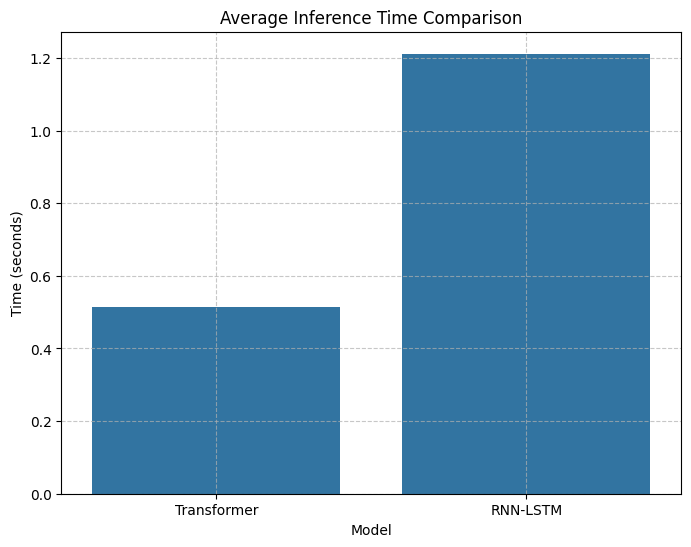


=== EXAMPLE GENERATED TITLES ===

Example 1:
 terrorists war criminals and any other criminals whose offenc 3899 chars...
Original Title: grid-scale battery storage is quietly revolutionizing the energy system
Transformer Title: the us
RNN-LSTM Title: the the the the the to
--------------------------------------------------------------------------------

Example 2:
 mcdonalds second quarter same store sales fell to their lowest levels in five years din 2444 chars...
Original Title: fun with technology
Transformer Title: the us
RNN-LSTM Title: the the the the the to to
--------------------------------------------------------------------------------

Example 3:
Content: a new darpa project called expmath aims to jumpstart math innovation with the help of ai writes the register americas defense advanced research projects agency believes mathematics isnt advan 2870 chars...
Original Title: what the last of us season premieres final moments really mean
Transformer Title: the us
RNN-LSTM Ti

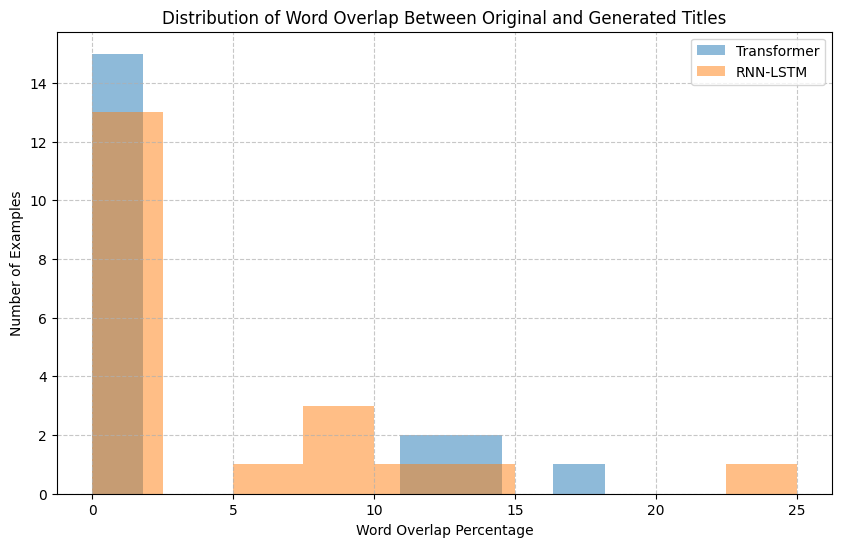

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import time

# Inisialisasi ROUGE
rouge = Rouge()

# Fungsi untuk generasi judul dengan Transformer (greedy decoding)
def generate_title_transformer_greedy(article_text, tokenizers, params, model, max_length=30):
    """
    Simplified greedy decoding for transformer model
    """
    # Preprocess article text
    article_text = preprocess_text(article_text)

    # Tokenize article
    content_tokenizer = tokenizers['content_tokenizer']
    title_tokenizer = tokenizers['title_tokenizer']

    article_seq = content_tokenizer.texts_to_sequences([article_text])
    article_padded = pad_sequences(article_seq, maxlen=params['max_content_length'],
                                  padding='post', truncating='post')

    # Initialize with start token
    start_token_idx = title_tokenizer.word_index.get('startseq', 1)

    # Fixed-length decoder input filled with padding (0)
    decoder_input = np.zeros((1, params['max_title_length']-1), dtype=np.int32)
    decoder_input[0, 0] = start_token_idx  # Set start token

    # Keep track of generated words
    generated_tokens = []

    # Generation loop
    for i in range(max_length):
        if i >= params['max_title_length']-1:
            break

        # Get model prediction
        prediction = model.predict([article_padded, decoder_input], verbose=0)

        # Get the next token (from current position)
        predicted_id = np.argmax(prediction[0, i])

        # Convert ID to word
        predicted_word = None
        for word, idx in title_tokenizer.word_index.items():
            if idx == predicted_id:
                predicted_word = word
                break

        # Stop if endseq token or unknown word
        if predicted_word == 'endseq' or predicted_word is None:
            break

        # Add word to results if not a special token
        if predicted_word not in ['startseq', 'endseq']:
            generated_tokens.append(predicted_word)

        # Add the word to decoder input for next iteration
        if i + 1 < params['max_title_length']-1:
            decoder_input[0, i+1] = predicted_id

    return ' '.join(generated_tokens)

# Fungsi untuk menghasilkan judul dengan model RNN-LSTM - DIREVISI
def generate_title_rnn_lstm(article_text, tokenizers, params, encoder_model, decoder_model, max_length=30):
    """
    Generate a title for an article using the RNN-LSTM model

    Args:
        article_text: Text of the article
        tokenizers: Dictionary containing content_tokenizer and title_tokenizer
        params: Dictionary containing model parameters
        encoder_model: Trained encoder model for inference
        decoder_model: Trained decoder model for inference
        max_length: Maximum length of generated title

    Returns:
        Generated title
    """
    # Preprocess article text
    article_text = preprocess_text(article_text)

    # Tokenize article - PERBAIKAN KUNCI DICTIONARY
    content_tokenizer = tokenizers['content_tokenizer']
    title_tokenizer = tokenizers['title_tokenizer']

    article_seq = content_tokenizer.texts_to_sequences([article_text])
    article_padded = pad_sequences(article_seq, maxlen=params['max_content_length'],
                                  padding='post', truncating='post')

    # Get encoder output
    states_value = encoder_model.predict(article_padded, verbose=0)

    # Initialize target sequence with start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = title_tokenizer.word_index.get('startseq', 1)

    # Store generated words
    generated_title = []

    # Generation loop
    for _ in range(max_length):
        # Predict next word
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Get the predicted word index
        predicted_index = np.argmax(output_tokens[0, 0, :])

        # Convert index to word
        predicted_word = None
        for word, index in title_tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break

        # Handle unknown words
        if predicted_word is None:
            predicted_word = "<UNK>"

        # Break if end token or reached max length
        if predicted_word == 'endseq':
            break

        # Add the word to the generated title
        if predicted_word not in ['startseq', 'endseq']:
            generated_title.append(predicted_word)

        # Update the target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = predicted_index

        # Update states
        states_value = [h, c]

    return ' '.join(generated_title)

# Fungsi untuk menghitung metrik BLEU dan ROUGE
def calculate_metrics(reference, prediction):
    # Jika prediksi kosong, kembalikan nilai 0
    if not prediction:
        return {
            'bleu1': 0, 'bleu2': 0, 'bleu3': 0, 'bleu4': 0,
            'rouge1': 0, 'rouge2': 0, 'rougeL': 0
        }

    # Prepare for BLEU (needs tokenized lists)
    reference_tokens = reference.split()
    prediction_tokens = prediction.split()

    # Calculate BLEU
    bleu1 = sentence_bleu([reference_tokens], prediction_tokens, weights=(1, 0, 0, 0))
    bleu2 = sentence_bleu([reference_tokens], prediction_tokens, weights=(0.5, 0.5, 0, 0))
    bleu3 = sentence_bleu([reference_tokens], prediction_tokens, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = sentence_bleu([reference_tokens], prediction_tokens, weights=(0.25, 0.25, 0.25, 0.25))

    # Calculate ROUGE (needs strings)
    try:
        rouge_scores = rouge.get_scores(prediction, reference)[0]
        rouge1_f = rouge_scores['rouge-1']['f']
        rouge2_f = rouge_scores['rouge-2']['f']
        rougeL_f = rouge_scores['rouge-l']['f']
    except:
        rouge1_f, rouge2_f, rougeL_f = 0, 0, 0

    return {
        'bleu1': bleu1,
        'bleu2': bleu2,
        'bleu3': bleu3,
        'bleu4': bleu4,
        'rouge1': rouge1_f,
        'rouge2': rouge2_f,
        'rougeL': rougeL_f
    }

# Evaluasi pada subset data validasi
num_eval_samples = 20
eval_indices = np.random.choice(X_val.shape[0], num_eval_samples, replace=False)

# Dictionary untuk menyimpan hasil
transformer_metrics = []
rnn_lstm_metrics = []
examples = []

# Mengukur waktu inferensi
transformer_times = []
rnn_lstm_times = []

for idx in tqdm(eval_indices, desc="Evaluating models"):
    # Get original content and title
    original_content = ' '.join([content_tokenizer.index_word.get(i, '<UNK>') for i in X_val[idx] if i != 0])
    original_title = df.iloc[idx]['clean_title']

    # Generate title with Transformer
    start_time = time.time()
    transformer_title = generate_title_transformer_greedy(
        original_content, tokenizers, params, transformer_model)
    transformer_time = time.time() - start_time
    transformer_times.append(transformer_time)

    # Generate title with RNN-LSTM
    start_time = time.time()
    rnn_lstm_title = generate_title_rnn_lstm(
        original_content, tokenizers, params, rnn_lstm_encoder_model, rnn_lstm_decoder_model)
    rnn_lstm_time = time.time() - start_time
    rnn_lstm_times.append(rnn_lstm_time)

    # Calculate metrics
    transformer_metrics.append(calculate_metrics(original_title, transformer_title))
    rnn_lstm_metrics.append(calculate_metrics(original_title, rnn_lstm_title))

    # Save examples
    examples.append({
        'content': original_content[:300] + "...",
        'original_title': original_title,
        'transformer_title': transformer_title,
        'rnn_lstm_title': rnn_lstm_title
    })

# Calculate average metrics
def calculate_average_metrics(metrics_list):
    avg_metrics = {}
    for metric in metrics_list[0].keys():
        avg_metrics[metric] = np.mean([metrics[metric] for metrics in metrics_list])
    return avg_metrics

avg_transformer_metrics = calculate_average_metrics(transformer_metrics)
avg_rnn_lstm_metrics = calculate_average_metrics(rnn_lstm_metrics)

# Calculate average inference time
avg_transformer_time = np.mean(transformer_times)
avg_rnn_lstm_time = np.mean(rnn_lstm_times)

# Create DataFrame for comparison
metrics_df = pd.DataFrame({
    'Metric': list(avg_transformer_metrics.keys()),
    'Transformer': list(avg_transformer_metrics.values()),
    'RNN-LSTM': list(avg_rnn_lstm_metrics.values())
})

# Add inference time
metrics_df = pd.concat([metrics_df, pd.DataFrame({
    'Metric': ['inference_time'],
    'Transformer': [avg_transformer_time],
    'RNN-LSTM': [avg_rnn_lstm_time]
})])

print("Average Evaluation Metrics:")
display(metrics_df)

# Visualize metrics comparison
plt.figure(figsize=(14, 8))

# BLEU scores
plt.subplot(1, 2, 1)
bleu_metrics = ['bleu1', 'bleu2', 'bleu3', 'bleu4']
bleu_df = metrics_df[metrics_df['Metric'].isin(bleu_metrics)]
bleu_df = bleu_df.melt(id_vars='Metric', var_name='Model', value_name='Score')
sns.barplot(x='Metric', y='Score', hue='Model', data=bleu_df)
plt.title('BLEU Scores Comparison')
plt.ylim(0, max(np.max(bleu_df['Score'])*1.2, 0.1))
plt.grid(True, linestyle='--', alpha=0.7)

# ROUGE scores
plt.subplot(1, 2, 2)
rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
rouge_df = metrics_df[metrics_df['Metric'].isin(rouge_metrics)]
rouge_df = rouge_df.melt(id_vars='Metric', var_name='Model', value_name='Score')
sns.barplot(x='Metric', y='Score', hue='Model', data=rouge_df)
plt.title('ROUGE Scores Comparison')
plt.ylim(0, max(np.max(rouge_df['Score'])*1.2, 0.1))
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Comparison of inference time
plt.figure(figsize=(8, 6))
time_df = metrics_df[metrics_df['Metric'] == 'inference_time']
time_df = time_df.melt(id_vars='Metric', var_name='Model', value_name='Time (seconds)')
sns.barplot(x='Model', y='Time (seconds)', data=time_df)
plt.title('Average Inference Time Comparison')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Display examples
print("\n=== EXAMPLE GENERATED TITLES ===")
for i, example in enumerate(examples[:5]):  # Show first 5 examples
    print(f"\nExample {i+1}:")
    print(f"Content: {example['content']}")
    print(f"Original Title: {example['original_title']}")
    print(f"Transformer Title: {example['transformer_title']}")
    print(f"RNN-LSTM Title: {example['rnn_lstm_title']}")
    print("-" * 80)

# Tambahan: Hitung persentase kemiripan kata antara judul asli dan prediksi
def calculate_word_overlap(reference, prediction):
    reference_words = set(reference.lower().split())
    prediction_words = set(prediction.lower().split())
    if not reference_words or not prediction_words:
        return 0
    overlap = reference_words.intersection(prediction_words)
    return len(overlap) / len(reference_words) * 100

# Hitung overlap rata-rata
transformer_overlaps = []
rnn_lstm_overlaps = []

for example in examples:
    transformer_overlaps.append(calculate_word_overlap(
        example['original_title'], example['transformer_title']))
    rnn_lstm_overlaps.append(calculate_word_overlap(
        example['original_title'], example['rnn_lstm_title']))

avg_transformer_overlap = np.mean(transformer_overlaps)
avg_rnn_lstm_overlap = np.mean(rnn_lstm_overlaps)

print(f"\n=== WORD OVERLAP ANALYSIS ===")
print(f"Transformer average word overlap: {avg_transformer_overlap:.2f}%")
print(f"RNN-LSTM average word overlap: {avg_rnn_lstm_overlap:.2f}%")

# Visualize word overlap distribution
plt.figure(figsize=(10, 6))
plt.hist(transformer_overlaps, alpha=0.5, bins=10, label='Transformer')
plt.hist(rnn_lstm_overlaps, alpha=0.5, bins=10, label='RNN-LSTM')
plt.title('Distribution of Word Overlap Between Original and Generated Titles')
plt.xlabel('Word Overlap Percentage')
plt.ylabel('Number of Examples')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()